In [43]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# generate a dataset

class MyDataset(Dataset):
    def __init__(self, n_grads, H):
        super().__init__()
        self.grads = np.random.uniform(-1, 1, size=n_grads)
        self.x = torch.arange(0, 1, 0.01)
        self.H = H # horizon [steps]
        self.interval = H//2 # [steps]

        self.len = n_grads

    def __getitem__(self, idx):
        """
        1. sample `grads`
        2. generate linear data (seq_len*input_size)
        Remarks: (batch_size*seq_len*input_size) is formed by DataLoader.
        """
        H = self.H

        # 1.
        grad = self.grads[idx]

        # 2.
        y = grad * self.x

        subys = torch.tensor([])  # (seq_len*input_size(H))
        i = 0
        while len(y[i:i+H]) == H:
            suby = y[i:i+H].view(1, -1)
            subys = torch.cat((subys, suby), 0)
            i += self.interval

        return subys, grad

    def __len__(self):
        return self.len

In [44]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.h_n = None  # hidden state
        self.c_n = None  # cell state

        # define the output layer
        self.linear = nn.Linear(self.hidden_dim, 1)  # predicts `linear-grad`

    def init_states(self, batch_size):
        """initialize the hidden and cell states"""
        self.h_n = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        self.c_n = torch.zeros(self.num_layers, batch_size, self.hidden_dim)

    def forward(self, x):
        states = (self.h_n, self.c_n)
        out, (self.h_n, self.c_n) = self.lstm(x, states)

        # get the last one of the (sequential) output from the LSTM
        out = out[:, -1, :]  # (batch, hidden_size)
        out = self.linear(out)  # (batch, 1)

        return out

In [45]:


# DataLoader
train_dataset = MyDataset(n_grads=30, H=10)
train_data_loader = DataLoader(train_dataset, batch_size=8)

val_dataset = MyDataset(n_grads=10, H=10)
val_data_loader = DataLoader(val_dataset, batch_size=8)


# Model
model = LSTM(input_dim=train_dataset.H,hidden_dim=32,num_layers=2)


# Compile
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

In [46]:
# Train
n_epochs = 100

for epoch in range(1, n_epochs+1):

    # train
    i, train_loss, val_loss = 0, 0., 0.
    for x, y in train_data_loader:
        optimizer.zero_grad()

        model.init_states(batch_size=x.shape[0])
        out = model(x)

        loss = criterion(out, y.float().view(-1, 1))
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        i += 1
    train_loss /= i

    # validate
    with torch.no_grad():
        i = 0
        for x, y in val_data_loader:
            model.init_states(batch_size=x.shape[0])
            out = model(x)
            loss = criterion(out, y.float().view(-1, 1))
            val_loss += loss.item()
            i += 1
        val_loss /= i

    print('epoch: {} | train_loss: {:0.5f} | val_loss: {:0.5f}'.format(epoch, train_loss, val_loss))

epoch: 1 | train_loss: 0.30529 | val_loss: 0.45667
epoch: 2 | train_loss: 0.27443 | val_loss: 0.43076
epoch: 3 | train_loss: 0.24448 | val_loss: 0.40052
epoch: 4 | train_loss: 0.21029 | val_loss: 0.36279
epoch: 5 | train_loss: 0.16894 | val_loss: 0.31438
epoch: 6 | train_loss: 0.12096 | val_loss: 0.25518
epoch: 7 | train_loss: 0.07610 | val_loss: 0.19261
epoch: 8 | train_loss: 0.05071 | val_loss: 0.13443
epoch: 9 | train_loss: 0.03407 | val_loss: 0.08010
epoch: 10 | train_loss: 0.01652 | val_loss: 0.04083
epoch: 11 | train_loss: 0.01258 | val_loss: 0.02166
epoch: 12 | train_loss: 0.01581 | val_loss: 0.01585
epoch: 13 | train_loss: 0.01441 | val_loss: 0.01448
epoch: 14 | train_loss: 0.00984 | val_loss: 0.01569
epoch: 15 | train_loss: 0.00724 | val_loss: 0.01772
epoch: 16 | train_loss: 0.00629 | val_loss: 0.01748
epoch: 17 | train_loss: 0.00549 | val_loss: 0.01408
epoch: 18 | train_loss: 0.00457 | val_loss: 0.00916
epoch: 19 | train_loss: 0.00379 | val_loss: 0.00543
epoch: 20 | train_los

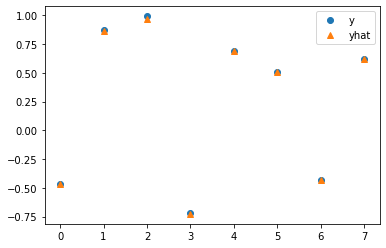

In [47]:
# Test
with torch.no_grad():
    for x, y in val_data_loader:
        model.init_states(batch_size=x.shape[0])
        out = model(x)
        break
        #loss = criterion(out, y.float().view(-1, 1))
        
# Plot
plt.plot(y.float(), 'o', label='y')
plt.plot(out.view(-1), '^', label='yhat')
plt.legend()